# Library Imports

## Parallelization libraries

In [6]:
try:
    cluster.close()
    client.shutdown()
except:
    pass

In [7]:
#libraries for parallelization
import dask_ml.model_selection
import dask_ml.metrics as dd_metric
from dask.distributed import Client, LocalCluster
from dask.distributed import Adaptive

# Create a local cluster with 12 workers, each using 2 threads
cluster = LocalCluster(n_workers=12, threads_per_worker=2)
client = Client(cluster)

import optuna
from numba import jit
from joblib import parallel_backend, effective_n_jobs
#import modin.pandas as pd
import dask.dataframe as dd
from dask import config
import dask_ml.model_selection as dcv  # for Dask's cross-validation
#import dpctl (Not supported for Nvidia GPU?)
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Standard Libraries

In [464]:
# libraries for file manipulation and warning handling
import os
import subprocess
import time
import logging
import warnings
from tqdm import tqdm
from joblib import dump, load
import zipfile
import gc

# Libraries for data handling
import re
import math
import numpy as np
import pandas as pd
from collections import Counter
import kaggle
import requests
import urllib.parse
import random

#imports for model training and validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, average_precision_score, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, confusion_matrix

#Recursive Feature Elimination
from sklearn.feature_selection import RFE 

#imports for preprocessing our data
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer, make_column_selector
from mlxtend.feature_selection import ColumnSelector

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

#imports for our classifier models
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB

#imports for plotting
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
%matplotlib inline

#imports for attractive printing of dataframes
from IPython.display import display

# Kaggle API Set Up

In [16]:
os.chdir(r"C:\Users\willa\Documents\GitHub\DTSA-5510\DTSA-5510 Kaggle Mini Project")

In [30]:
os.getcwd()

str

In [92]:
def convert_byte_size_to_bytes(byte_size_str):
    # Regular expression to extract numeric and unit parts
    match = re.match(r'^(\d+)([KMGT]B)?$', byte_size_str, re.IGNORECASE)

    if match:
        # Extract the numeric part and unit part
        numeric_part = int(match.group(1))
        unit_part = match.group(2)

        # Define conversion factors for different units (KB, MB, GB, TB)
        units = {'KB': 1024, 'MB': 1024**2, 'GB': 1024**3, 'TB': 1024**4}

        # Convert to bytes
        if unit_part:
            unit_part = unit_part.upper()  # Convert unit to uppercase for case-insensitive matching
            if unit_part in units:
                return numeric_part * units[unit_part]
            else:
                raise ValueError(f"Unsupported unit: {unit_part}")
        else:
            return numeric_part

    else:
        raise ValueError("Invalid byte size format")

In [126]:
def Kaggle_Data_Pull(competition_name = 'learn-ai-bbc', usr_path='./data/', file_return=False):
        print("Grabbing file names from Kaggle...")
        files = kaggle.api.competition_list_files(competition_name)
        file_names = [i.name for i in files]
        file_sizes = [i.size for i in files]
    
        print('Downloading from Kaggle...')
        for file, size in zip(file_names, file_sizes):
            
            kaggle.api.competition_download_file(competition_name, file, usr_path)
            
            if convert_byte_size_to_bytes(size) >= convert_byte_size_to_bytes('1MB'):
                file = file + '.zip'
            else:
                pass
                
            file = urllib.parse.quote(file)
            
            if file.endswith('.zip'):
                print(f"Extracting '{file}'...")
                with zipfile.ZipFile(usr_path + file, 'r') as zip_ref:
                    zip_ref.extractall(usr_path)  # Extract to the current directory or specify a different path
                print(f"Finished extracting '{file}'.")
            
            print(f"Files pulled to: {os.getcwd()}")
            
        for root, _, files in os.walk(usr_path):
            for filename in files:
                # Full path to the file
                file_path = os.path.join(root, filename)
    
                # Decode the filename to remove URL-encoded characters
                decoded_filename = urllib.parse.unquote(filename)
    
                # Get new file name
                new_file_path = os.path.join(root, decoded_filename)
                
                # Check if the renamed file already exists
                if os.path.exists(new_file_path):
                    print(f"File '{decoded_filename}' already exists, skipping.")
                else:
                    #Rename the file
                    os.rename(file_path, new_file_path)
                    # Print the renaming operation
                    print(f"Renamed '{filename}' to '{decoded_filename}'")
                    
        if file_return:
            return files

In [485]:
def perform_kfold_cv(X_train, y_train):
    # Models for Classification
    models = [('LR', LogisticRegression(max_iter=10000, random_state=5)),
              ('CART', DecisionTreeClassifier(random_state=5)),
              ('RF', RandomForestClassifier(random_state=5)),
              ("LightGBM", LGBMClassifier(verbose= -1, random_state=5)),
              ("MultiNB", MultinomialNB())
             ]

    results = []
    names = []
    best_models = []  # To store the best model from each cross-validation

    # Manual k-fold cross-validation
    kfold = KFold(n_splits=10, random_state=5, shuffle=True)

    for name, model in models:
        fold_scores = []

        best_model = None
        best_score = float('-inf')  # For classification, assuming you want higher scores to be better

        for train_idx, valid_idx in kfold.split(X_train, y_train):
            train_data, valid_data = X_train[train_idx], X_train[valid_idx]
            train_target, valid_target = y_train[train_idx], y_train[valid_idx]

            temp_model = clone(model)  # Create a fresh clone of the model
            temp_model.fit(train_data, train_target)

            # Predict directly on CSR matrix
            y_pred = temp_model.predict(valid_data)

            score = accuracy_score(valid_target, y_pred)
            fold_scores.append(score)

            if score > best_score:
                best_score = score
                best_model = temp_model

        results.append(fold_scores)
        names.append(name)
        best_models.append(best_model)

        msg = "%s: %f (%f)" % (name, np.mean(fold_scores), np.std(fold_scores))
        print(msg)

    return names, best_models, results

from sklearn.preprocessing import label_binarize

def evaluate_and_plot_models(names, best_models, X_test, y_test, set_name='', plot_pr_curves=True):
    # Initialize figure for plotting
    fig, axes = plt.subplots(nrows=len(best_models), ncols=2, figsize=(20, 50))

    # Metrics storage
    metrics_data = []

    for idx, (name, model) in enumerate(zip(names, best_models)):
        
        # Perform binary classification for each class separately
        y_pred_prob = model.predict_proba(X_test)
        n_classes = y_pred_prob.shape[1]
        
        for i in range(n_classes):
            y_test_binary = label_binarize(y_test, classes=[i])  # Binary labels for class i
            y_pred_prob_class = y_pred_prob[:, i]  # Predicted probabilities for class i
            
            # Metrics
            if plot_pr_curves:
                precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_prob_class)
                auc_pr = average_precision_score(y_test_binary, y_pred_prob_class)
                
                # Plot precision-recall curve for class i
                axes[idx, 0].plot(recall, precision, label=f'Class {i} (AUC-PR = %0.2f)' % auc_pr)

        axes[idx, 0].set_xlabel('Recall')
        axes[idx, 0].set_ylabel('Precision')
        axes[idx, 0].set_title(f'{set_name} Precision-Recall Curves for %s' % name)
        axes[idx, 0].legend(loc="lower left")

        # Other metrics for binary classification (e.g., accuracy, MCC) can be calculated here
        
        # Confusion matrix for multiclass classification
        cf_matrix = confusion_matrix(y_test, y_pred)
        cax = axes[idx, 1].imshow(cf_matrix, cmap='Blues')
        axes[idx, 1].set_title(f'{set_name} Confusion Matrix for %s' % name)
        axes[idx, 1].set_xlabel('Predicted')
        axes[idx, 1].set_ylabel('True')
        axes[idx, 1].set_xticks(range(n_classes))
        axes[idx, 1].set_yticks(range(n_classes))
        axes[idx, 1].set_xticklabels([f'Class {i}' for i in range(n_classes)])
        axes[idx, 1].set_yticklabels([f'Class {i}' for i in range(n_classes)])

        # Add annotations to the heatmap
        for i in range(n_classes):
            for j in range(n_classes):
                axes[idx, 1].text(j, i, cf_matrix[i, j], ha='center', va='center', color='lime')

    fig.tight_layout()
    plt.show()

In [446]:
class data_handler:
    def __init__(self):
        files = Kaggle_Data_Pull(file_return=True)
        self.full_train, self.X_train, self.X_test, self.y_train, self.y_test = self.file_to_data(files)
        self.encode_categories()
        self.vectorize_text()
        
    def file_to_data(self, files, usr_path = './data/'):
        for file in files:
            #parse any url characters from filename
            file = urllib.parse.unquote(file)

            if 'train' in file.lower():
                #grab test csv
                df_train = pd.read_csv(usr_path + file)
                
                #split to X and y component
                X_train = df_train.drop(columns=['Category'])
                y_train = df_train['Category']
                
            elif 'test' in file.lower():
                X_test = pd.read_csv(usr_path + file) 
                
            else:
                y_test = pd.read_csv(usr_path +  file)['Category']
        
        return df_train, X_train, X_test, y_train, y_test

    def encode_categories(self):
        encoder = LabelEncoder()
        self.y_train_encoded = encoder.fit_transform(self.y_train)
        self.y_test_encoded = encoder.transform(self.y_test)

    def vectorize_text(self):
        #Handle ArticleId
        #Mismatched size after processing, would drop later anyway since it is a unique identifier
        # pass_articleid = ColumnSelector(cols=('ArticleId'), drop_axis = True)
        # pass_articleid_pipe = Pipeline([('pass_article', pass_articleid)])
        
        #vector_count
        word_count_vectorizer = CountVectorizer(analyzer='word', max_features=5000)
        word2count_pipe = Pipeline([
            ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
            ('word2count', word_count_vectorizer)
        ])
        
        #Term Frequency - Inverse Document Frequency (TF-IDF)
        #Word-Level
        word_vectorizer = TfidfVectorizer(analyzer='word', max_features=5000)
        word2vec_pipe = Pipeline([
            ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
            ('word2vec', word_vectorizer)
        ])
        
        #N-gram Level
        ngram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000)
        ngram2vec_pipe = Pipeline([
            ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
            ('ngram2vec', ngram_vectorizer)
        ])
        
        
        #Character Level
        character_vectorizer = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        char2vec_pipe = Pipeline([
            ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
            ('char2vec', character_vectorizer)
        ])
        
        
        #Feature Union of Pipelines
        feats = FeatureUnion([('word_count', word2count_pipe), 
                              ('word_vec', word2vec_pipe),
                              ('ngram_vec', ngram2vec_pipe),
                              ('char_vec', char2vec_pipe)
                              ], transformer_weights=None, verbose=True)
        
        feature_processing = Pipeline([('feats', feats)])

        self.X_train_vectorized = feature_processing.fit_transform(self.full_train)
        self.X_test_vectorized = feature_processing.transform(self.X_test)

#  Exploratory Data Analysis

In [447]:
data = data_handler()

Grabbing file names from Kaggle...
BBC%20News%20Test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracting 'BBC%20News%20Test.csv.zip'...
Finished extracting 'BBC%20News%20Test.csv.zip'.
Files pulled to: C:\Users\willa\Documents\GitHub\DTSA-5510\DTSA-5510 Kaggle Mini Project
BBC%20News%20Sample%20Solution.csv: Skipping, found more recently modified local copy (use --force to force download)
Files pulled to: C:\Users\willa\Documents\GitHub\DTSA-5510\DTSA-5510 Kaggle Mini Project
BBC%20News%20Train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracting 'BBC%20News%20Train.csv.zip'...
Finished extracting 'BBC%20News%20Train.csv.zip'.
Files pulled to: C:\Users\willa\Documents\GitHub\DTSA-5510\DTSA-5510 Kaggle Mini Project
File 'BBC News Sample Solution.csv' already exists, skipping.
File 'BBC News Test.csv' already exists, skipping.
File 'BBC News Test.csv.zip' already exists, skipping.
File 'BBC

C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


[FeatureUnion] ...... (step 4 of 4) Processing char_vec, total=   1.8s


In [423]:
data.full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [424]:
data.full_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ArticleId,1490.0,1119.696644,641.826283,2.0,565.25,1112.5,1680.75,2224.0


In [425]:
pd.merge(data.X_test, data.y_test, left_index=True, right_index=True).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
 2   Category   735 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.4+ KB


In [426]:
pd.merge(data.X_test, data.y_test, left_index=True, right_index=True).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
 2   Category   735 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.4+ KB


## Dataset Description:

Our dataset is a colelction of articles from the BBC consisting of dataframes of Article ID, Text (Article Text Content), and Category (Article Category).

Our training set consists of 1490 entries, all non-null

Our test set consists of 735 entries, all non-null

|Column|Type|Description|
|---------|----|:--------:|
|ArticleID|Nominal Int| Unique Article identifier|
|Text| String | Text content of article - decomposable into characters, words, and N-grams|
|Category| Categorical String | Article category label |

## Text length

### Overall Text Length per Article

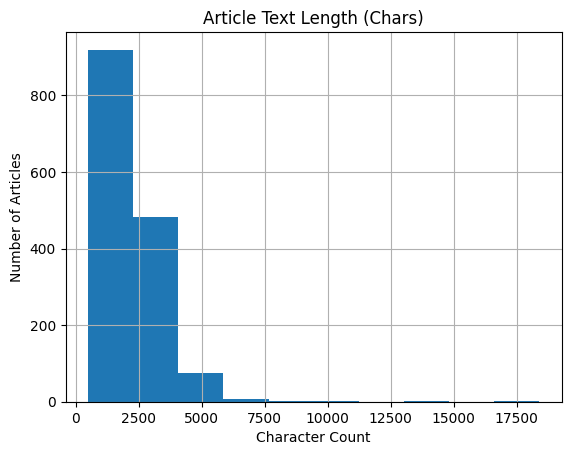

In [332]:
pd.DataFrame(data.full_train.apply(lambda x : len(x['Text']), axis=1).sort_values(ascending=False)).rename(columns={0:'Character_Count'}).hist()
plt.title('Article Text Length (Chars)')
plt.ylabel('Number of Articles')
plt.xlabel('Character Count')
plt.show()

Articles tend overall towards a length under ~4000 characters.

### Number of Articles by Character Count per Category

C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Number of Articles by Character Count per Category')

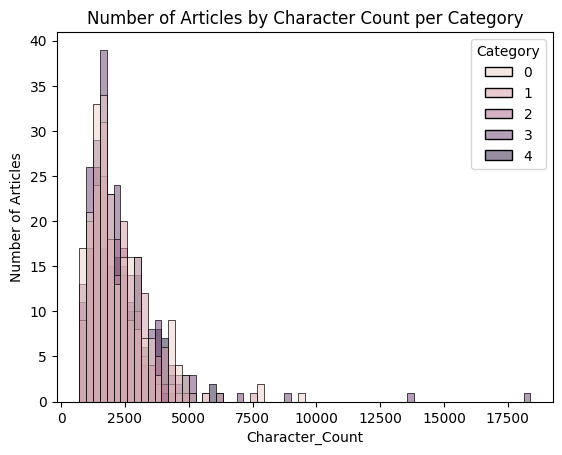

In [333]:
df_char_count = data.full_train.merge(pd.DataFrame(data.full_train.apply(lambda x : len(x['Text']), axis=1).sort_values(ascending=False)).rename(columns={0:'Character_Count'}).reset_index(), left_on='ArticleId', right_on='index')
sns.histplot(x='Character_Count', data=df_char_count, hue='Category', stat='count')
plt.ylabel('Number of Articles')
plt.title('Number of Articles by Character Count per Category')

No clear segmentation in the number of articles by character count per category, article length not visually indicative of likely category

## Distribution of ArticleID by Category

C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


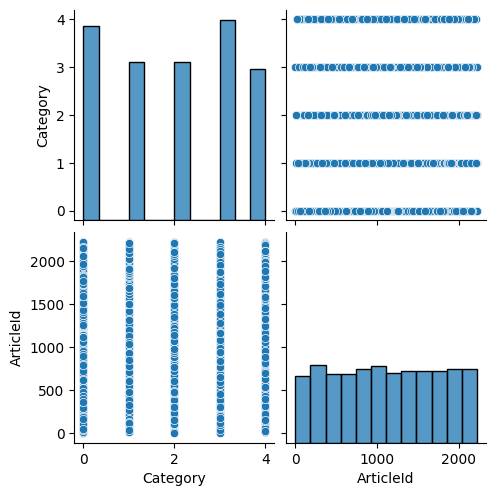

In [334]:
sns.pairplot(vars=['Category','ArticleId'], data=data.full_train)

There is no correlation between assigned ArticleId and article Category, ArticleId is consistent with iterative unique ID without regard for article content.

# Feature Preprocessing

Text needs to be vectorized in order to be handled by most classification models

In [449]:
#Handle ArticleId
#Mismatched size after processing, would drop later anyway since it is a unique identifier
# pass_articleid = ColumnSelector(cols=('ArticleId'), drop_axis = True)
# pass_articleid_pipe = Pipeline([('pass_article', pass_articleid)])

#vector_count
word_count_vectorizer = CountVectorizer(analyzer='word', max_features=5000)
word2count_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('word2count', word_count_vectorizer)
])

#Term Frequency - Inverse Document Frequency (TF-IDF)
#Word-Level
word_vectorizer = TfidfVectorizer(analyzer='word', max_features=5000)
word2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('word2vec', word_vectorizer)
])

#N-gram Level
ngram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000)
ngram2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('ngram2vec', ngram_vectorizer)
])


#Character Level
character_vectorizer = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
char2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('char2vec', character_vectorizer)
])


#Feature Union of Pipelines
feats = FeatureUnion([('word_count', word2count_pipe), 
                      ('word_vec', word2vec_pipe),
                      ('ngram_vec', ngram2vec_pipe),
                      ('char_vec', char2vec_pipe)
                      ], transformer_weights=None, verbose=True)

feature_processing = Pipeline([('feats', feats)])

In [450]:
feature_processing.fit_transform(data.full_train)

[FeatureUnion] .... (step 1 of 4) Processing word_count, total=   0.3s
[FeatureUnion] ...... (step 2 of 4) Processing word_vec, total=   0.3s
[FeatureUnion] ..... (step 3 of 4) Processing ngram_vec, total=   2.3s


C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


[FeatureUnion] ...... (step 4 of 4) Processing char_vec, total=   1.7s


<1490x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2378741 stored elements in Compressed Sparse Row format>

In [451]:
feature_processing.named_steps['feats']['word_count'].named_steps['word2count'].get_feature_names_out().shape

(5000,)

In [452]:
feature_processing.named_steps['feats']['word_vec'].named_steps['word2vec'].get_feature_names_out().shape

(5000,)

In [453]:
feature_processing.named_steps['feats']['ngram_vec'].named_steps['ngram2vec'].get_feature_names_out().shape

(5000,)

In [454]:
feature_processing.named_steps['feats']['word_count'].named_steps['word2count'].get_feature_names_out().shape

(5000,)

In [455]:
feature_processing.named_steps['feats']['char_vec'].named_steps['char2vec'].get_feature_names_out().shape

(5000,)

## Building the above processing steps in to the data_handler

In [389]:
data.full_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,4
4,917,enron bosses in $168m payout eighteen former e...,0
...,...,...,...
1485,857,double eviction from big brother model caprice...,1
1486,325,dj double act revamp chart show dj duo jk and ...,1
1487,1590,weak dollar hits reuters revenues at media gro...,0
1488,1587,apple ipod family expands market apple has exp...,4


In [433]:
data.X_train_vectorized

<1490x59492 sparse matrix of type '<class 'numpy.float64'>'
	with 2468353 stored elements in Compressed Sparse Row format>

In [434]:
data.X_test_vectorized

<735x59492 sparse matrix of type '<class 'numpy.float64'>'
	with 1217740 stored elements in Compressed Sparse Row format>

In [435]:
data.y_train_encoded.shape

(1490,)

In [437]:
data.y_test_encoded.shape

(735,)

The above should be usable for supervised model training now

# Model Building & Training (Matrix Factorization)

# Supervised Learning Model

In [472]:
#Base case model using LogRegClassifier
model = LogisticRegression(random_state=5, max_iter=10000)
model.fit(data.X_train_vectorized, data.y_train_encoded)
y_pred = model.predict(data.X_test_vectorized)

accuracy_score(y_pred, data.y_test_encoded)

0.19183673469387755

## Several Supervised Models with KFoldCV

In [470]:
print("| Model | Avg. Fold Score | (Std Fold Score) |")
names, best_models, results = perform_kfold_cv(data.X_train_vectorized, data.y_train_encoded)
display(results)

| Model | Avg. Fold Score | (Std Fold Score) |
LR: 0.961074 (0.014947)
CART: 0.776510 (0.036766)
RF: 0.944966 (0.015825)
LightGBM: 0.963758 (0.011702)
MultiNB: 0.972483 (0.012173)


[[0.9865771812080537,
  0.9731543624161074,
  0.9395973154362416,
  0.9664429530201343,
  0.9463087248322147,
  0.9395973154362416,
  0.9530201342281879,
  0.9664429530201343,
  0.9731543624161074,
  0.9664429530201343],
 [0.8120805369127517,
  0.697986577181208,
  0.7651006711409396,
  0.8053691275167785,
  0.7583892617449665,
  0.785234899328859,
  0.7516778523489933,
  0.7651006711409396,
  0.8389261744966443,
  0.785234899328859],
 [0.9798657718120806,
  0.9328859060402684,
  0.9261744966442953,
  0.9328859060402684,
  0.9328859060402684,
  0.9395973154362416,
  0.959731543624161,
  0.9395973154362416,
  0.959731543624161,
  0.9463087248322147],
 [0.9664429530201343,
  0.959731543624161,
  0.9530201342281879,
  0.959731543624161,
  0.9463087248322147,
  0.9798657718120806,
  0.9664429530201343,
  0.9530201342281879,
  0.9664429530201343,
  0.9865771812080537],
 [0.9798657718120806,
  0.9865771812080537,
  0.959731543624161,
  0.9530201342281879,
  0.9798657718120806,
  0.9664429530

# Model Comparison

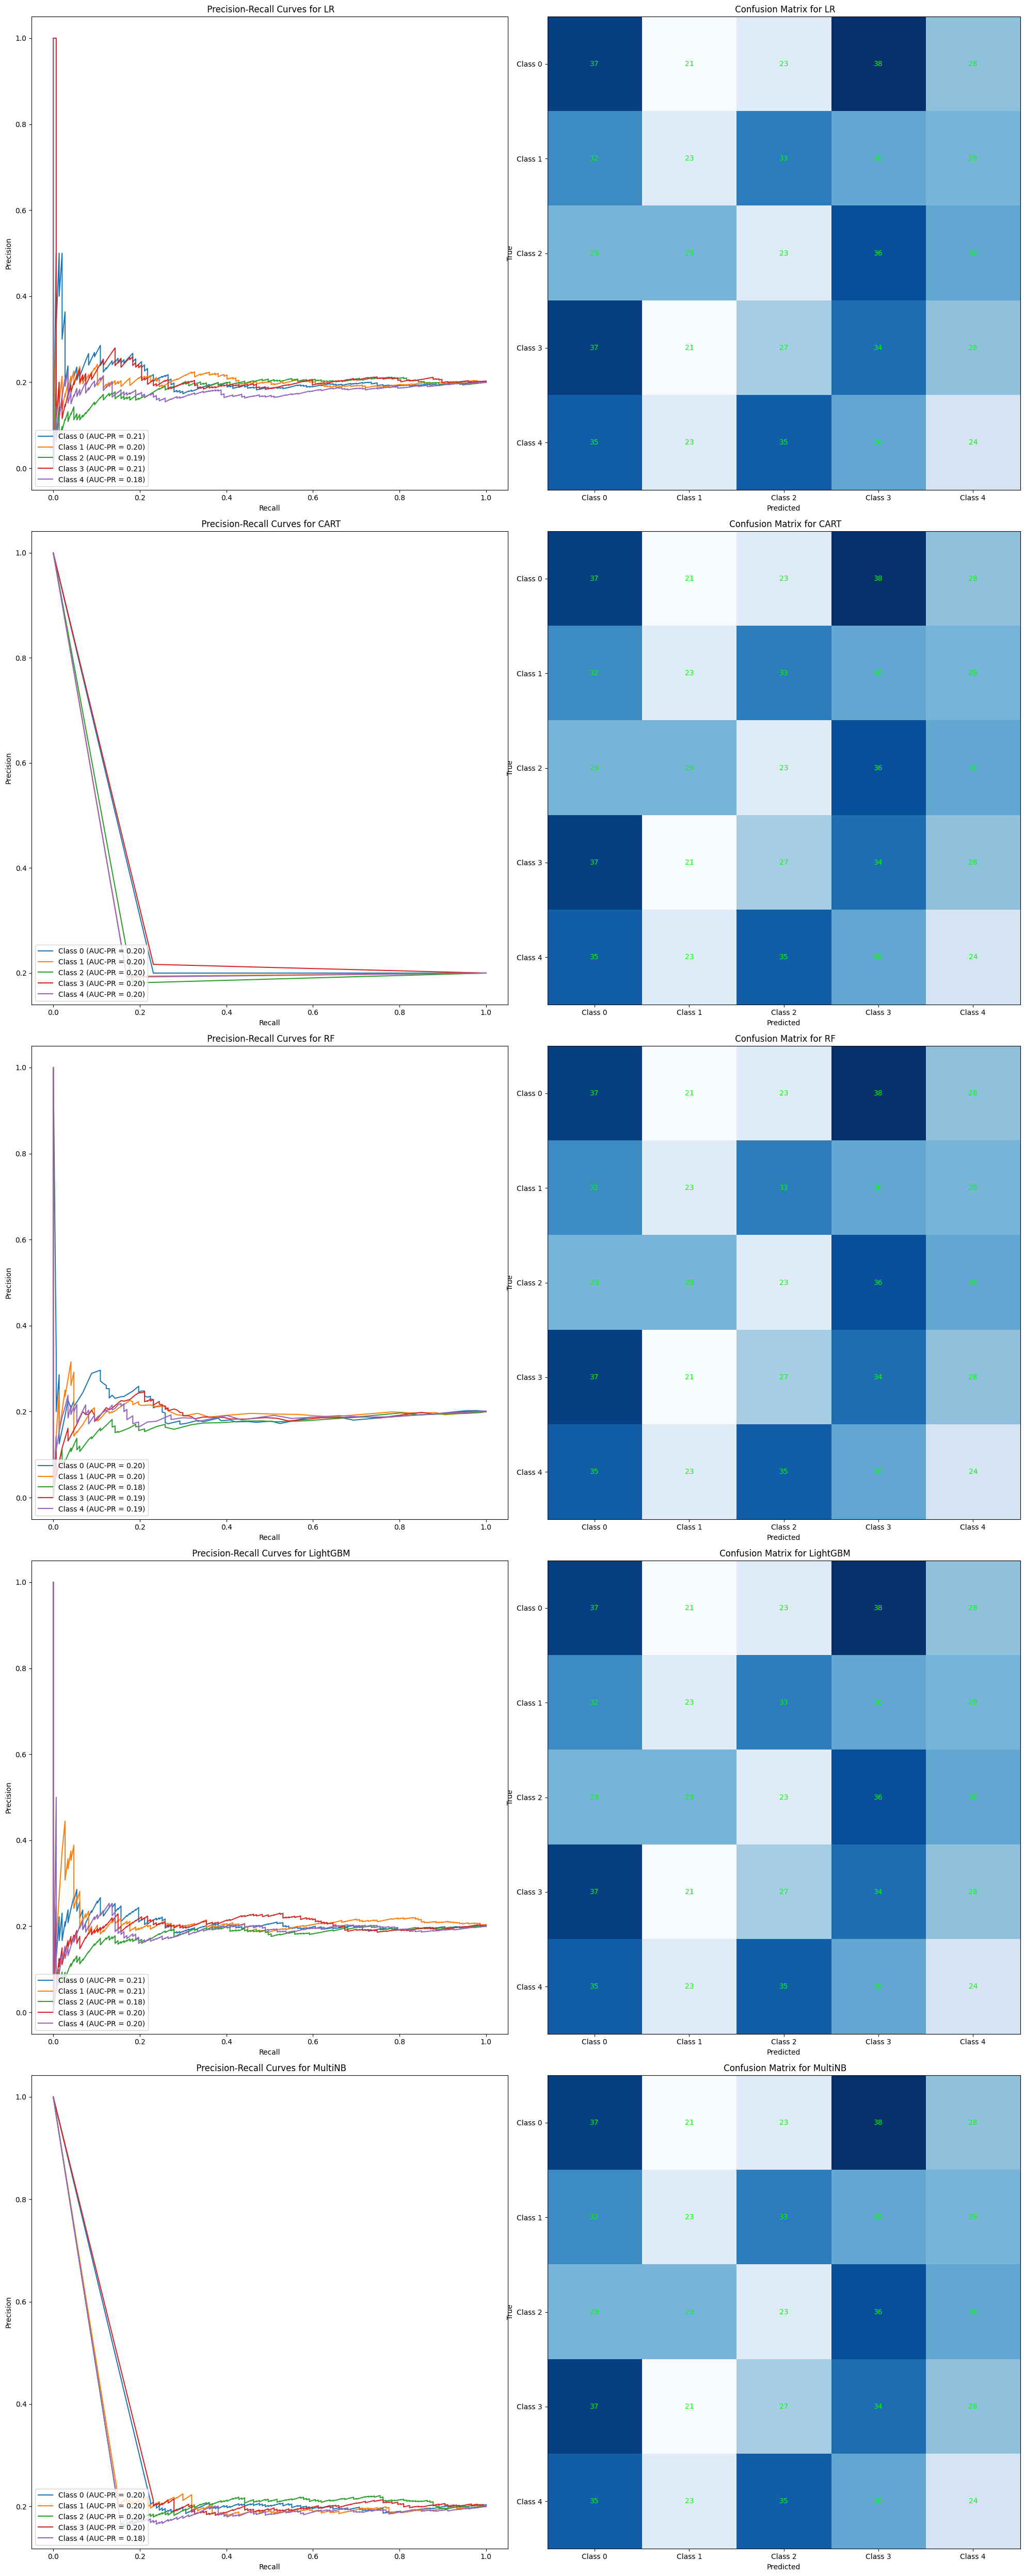

In [487]:
evaluate_and_plot_models(names, best_models, data.X_test_vectorized, data.y_test_encoded, plot_pr_curves=True)

In [492]:
for name, model in zip(names, best_models):
    print(name)
    print(classification_report(data.y_test_encoded, model.predict(data.X_test_vectorized)))

LR
              precision    recall  f1-score   support

           0       0.21      0.24      0.22       147
           1       0.20      0.16      0.18       147
           2       0.16      0.16      0.16       147
           3       0.20      0.23      0.22       147
           4       0.17      0.17      0.17       147

    accuracy                           0.19       735
   macro avg       0.19      0.19      0.19       735
weighted avg       0.19      0.19      0.19       735

CART
              precision    recall  f1-score   support

           0       0.20      0.23      0.21       147
           1       0.19      0.17      0.18       147
           2       0.18      0.18      0.18       147
           3       0.22      0.23      0.22       147
           4       0.19      0.17      0.18       147

    accuracy                           0.20       735
   macro avg       0.20      0.20      0.20       735
weighted avg       0.20      0.20      0.20       735

RF
           